# Experiments with simple models and with using TensorBoard

Useful link: https://towardsdatascience.com/a-complete-guide-to-using-tensorboard-with-pytorch-53cb2301e8c3

In [1]:
from utils import *

In [2]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs/nf_initial_experiments', comment="with_simpleDense")

In [3]:
base = nf.distributions.base.DiagGaussian(2)
flows = [AffineSingleBlock(SimpleDense(1, 4))]
flows += [Swap()]
flows += [AffineSingleBlock(SimpleDense(1, 4))]
flows += [Swap()]

model = MyNormFlow(q0 = base, flows = flows)

In [4]:
writer.add_graph(model, torch.tensor([[0.0, 0.0]]))
writer.close()

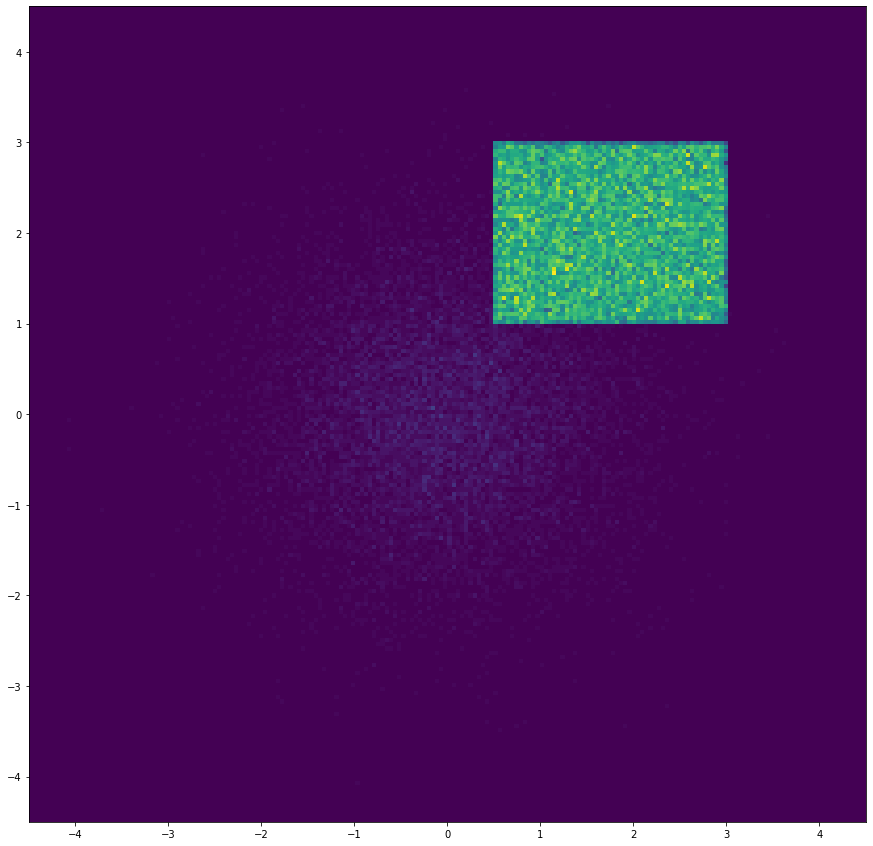

In [5]:
# Target distribution:

K_intervals = torch.Tensor([[0.5, 1],
                        [3,3]])
prob_delta = 0.1

nu = NormUnif(x_dim = 2, prob_delta=prob_delta, K_intervals=K_intervals)

x_np = nu.forward(100000)[0].numpy()
plt.figure(figsize=(15, 15))
plt.hist2d(x_np[:, 0], x_np[:, 1], bins=200, range=[[-4.5, 4.5], [-4.5, 4.5]])
plt.show()

c:\Users\Sacia\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


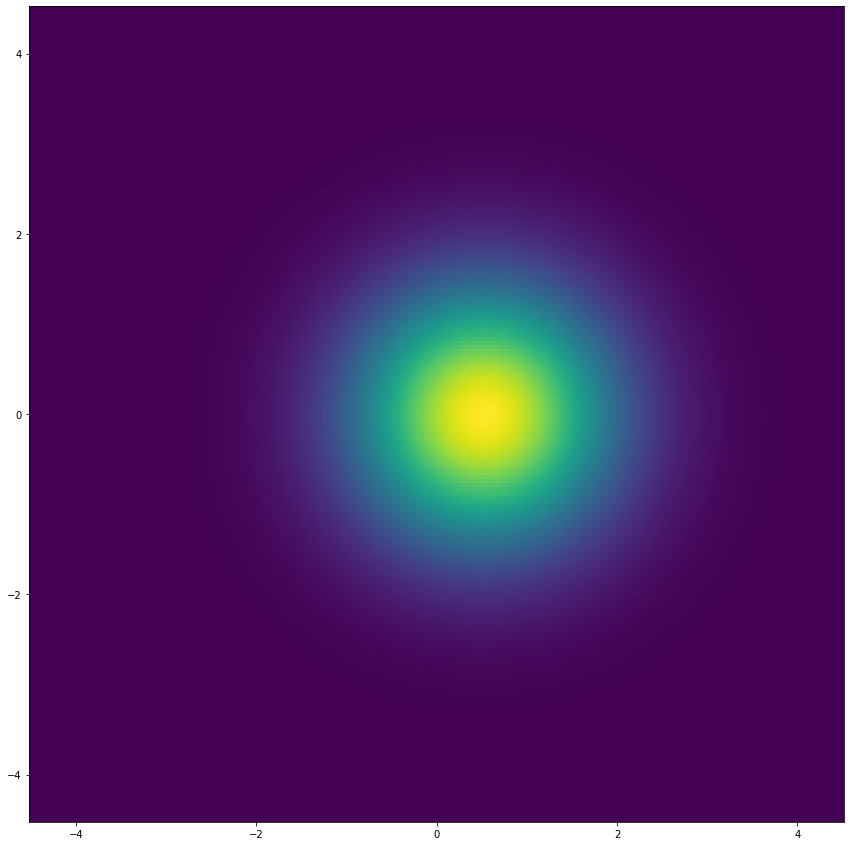

In [6]:
# Plot initial flow distribution
grid_size = 200
#xx, yy = torch.meshgrid(torch.linspace(-1.5, 2.5, grid_size), torch.linspace(-2, 2, grid_size))
xx, yy = torch.meshgrid(torch.linspace(-4.5, 4.5, grid_size), torch.linspace(-4.5, 4.5, grid_size))
zz = torch.cat([xx.unsqueeze(2), yy.unsqueeze(2)], 2).view(-1, 2)


model.eval()
log_prob = model.log_prob(zz).to('cpu').view(*xx.shape)
model.train()
prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = 0

plt.figure(figsize=(15, 15))
plt.pcolormesh(xx, yy, prob.data.numpy(), shading='auto')
plt.gca().set_aspect('equal', 'box')
plt.show()

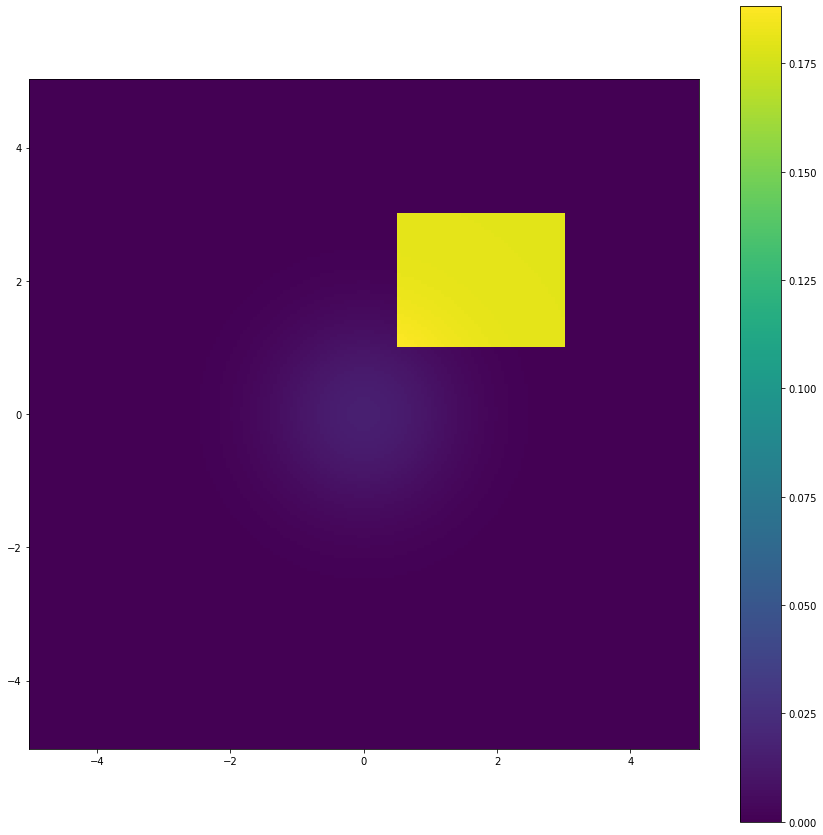

In [7]:
# Plot distribution
import matplotlib.pyplot as plt

middle_point = [0,0]
range_p = [5, 5]

grid_size = 200
xx, yy = torch.meshgrid(torch.linspace((middle_point[0]-range_p[0]), (middle_point[0]+range_p[0]), grid_size), torch.linspace((middle_point[1]-range_p[1]), (middle_point[1]+range_p[1]), grid_size))
zz = torch.cat([xx.unsqueeze(2), yy.unsqueeze(2)], 2).view(-1, 2)

prob = nu.calculate_pdf(zz)[:, None].reshape(200, 200)

plt.figure(figsize=(15, 15))
c =  plt.pcolormesh(xx, yy, prob, shading='auto') #'nearest' or 'gouraud
plt.colorbar(c)
plt.gca().set_aspect('equal', 'box')
plt.show()

 12%|█▏        | 499/4000 [02:17<16:57,  3.44it/s]<ipython-input-8-a284bc85e226>:41: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, prob.data.numpy())


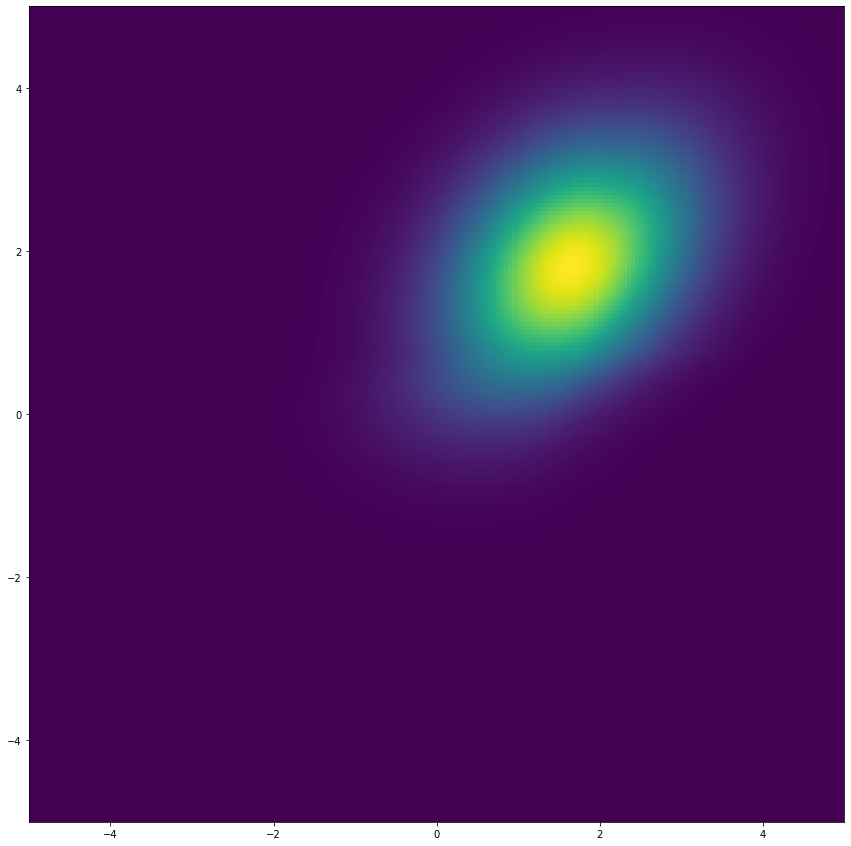

 25%|██▍       | 999/4000 [04:20<12:23,  4.04it/s]

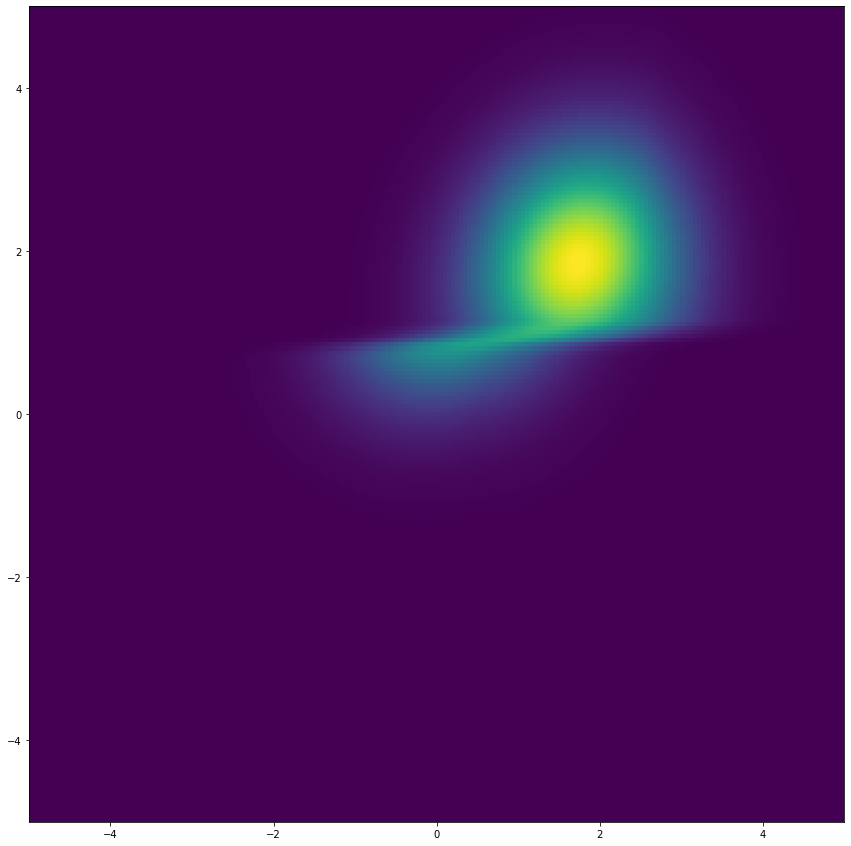

 37%|███▋      | 1499/4000 [06:13<08:49,  4.72it/s]

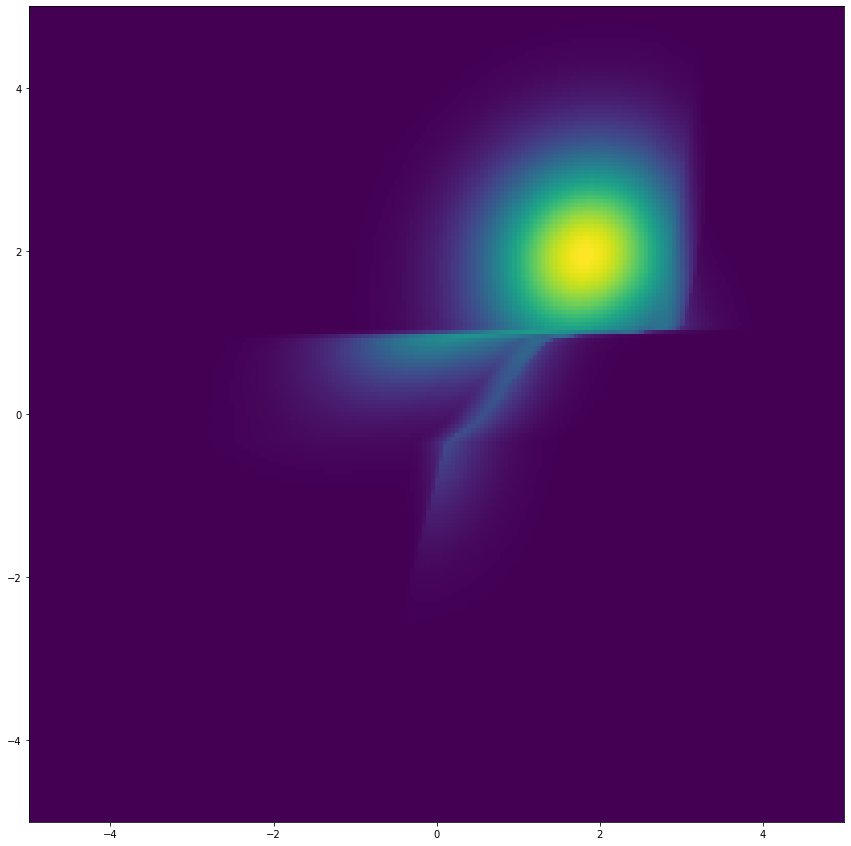

 50%|████▉     | 1999/4000 [08:10<07:59,  4.18it/s]

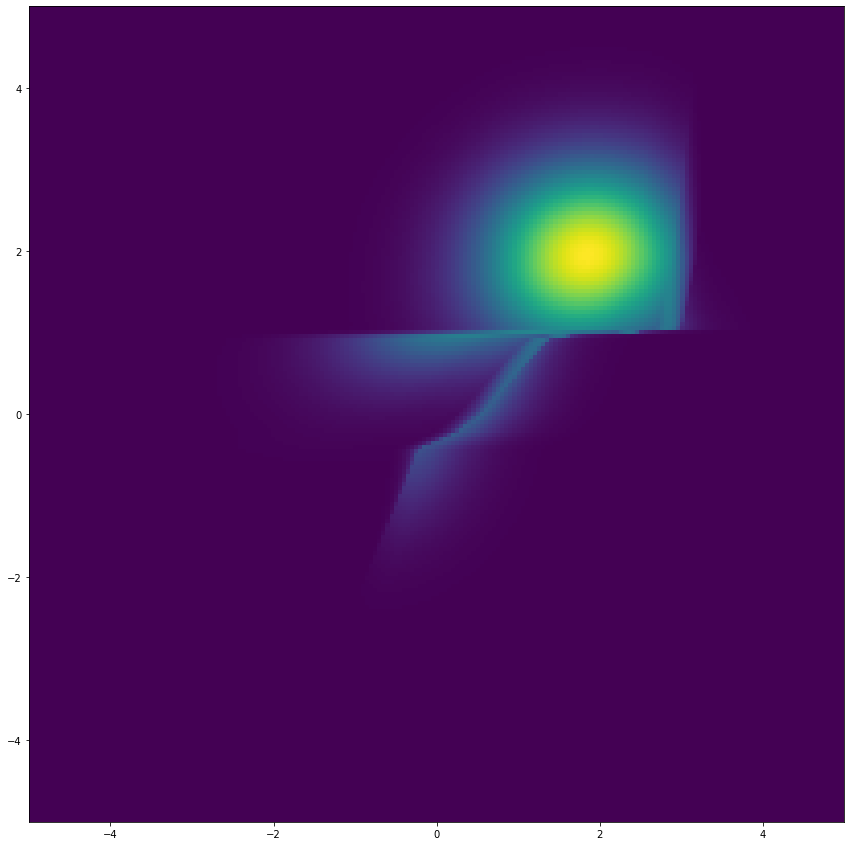

 62%|██████▏   | 2499/4000 [10:05<05:42,  4.38it/s]

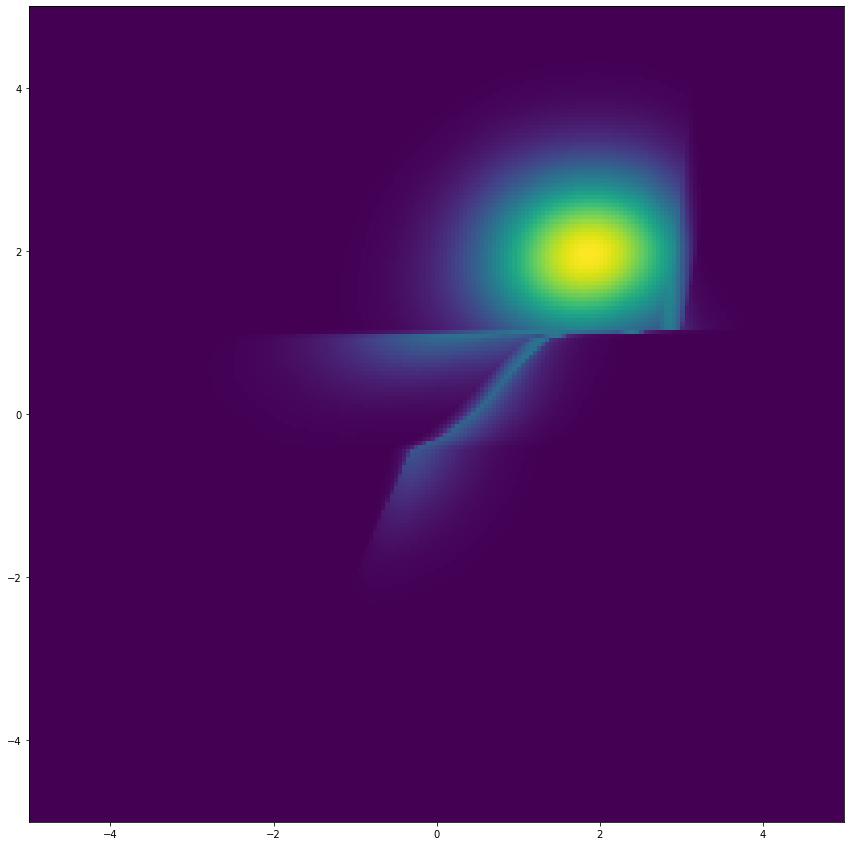

 75%|███████▍  | 2999/4000 [11:57<03:38,  4.59it/s]

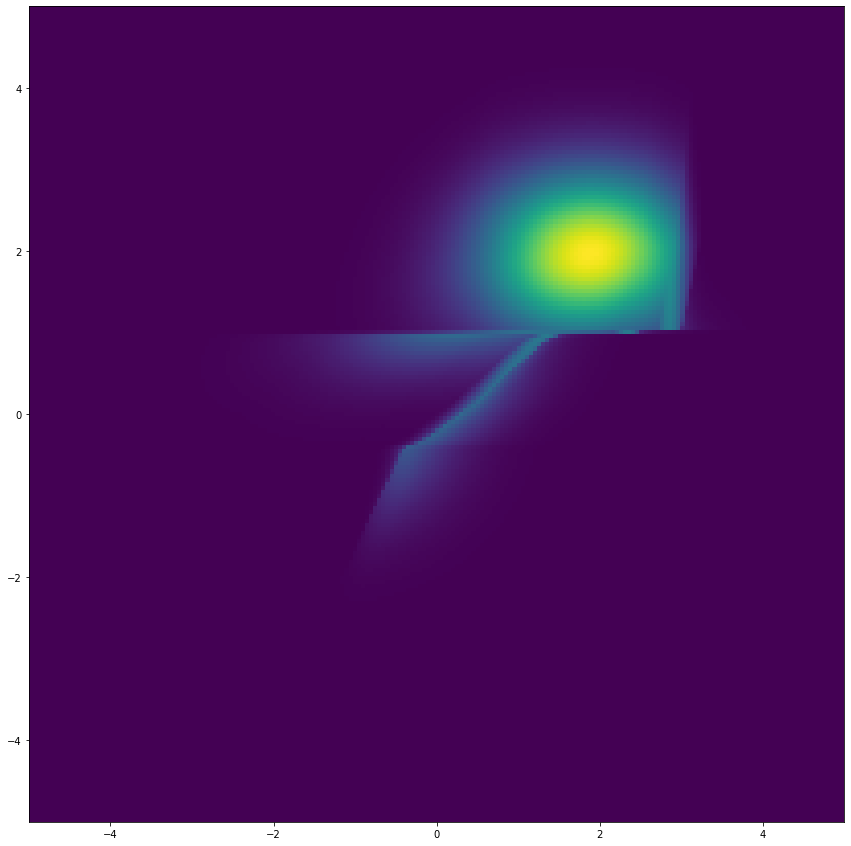

 87%|████████▋ | 3499/4000 [13:50<01:52,  4.45it/s]

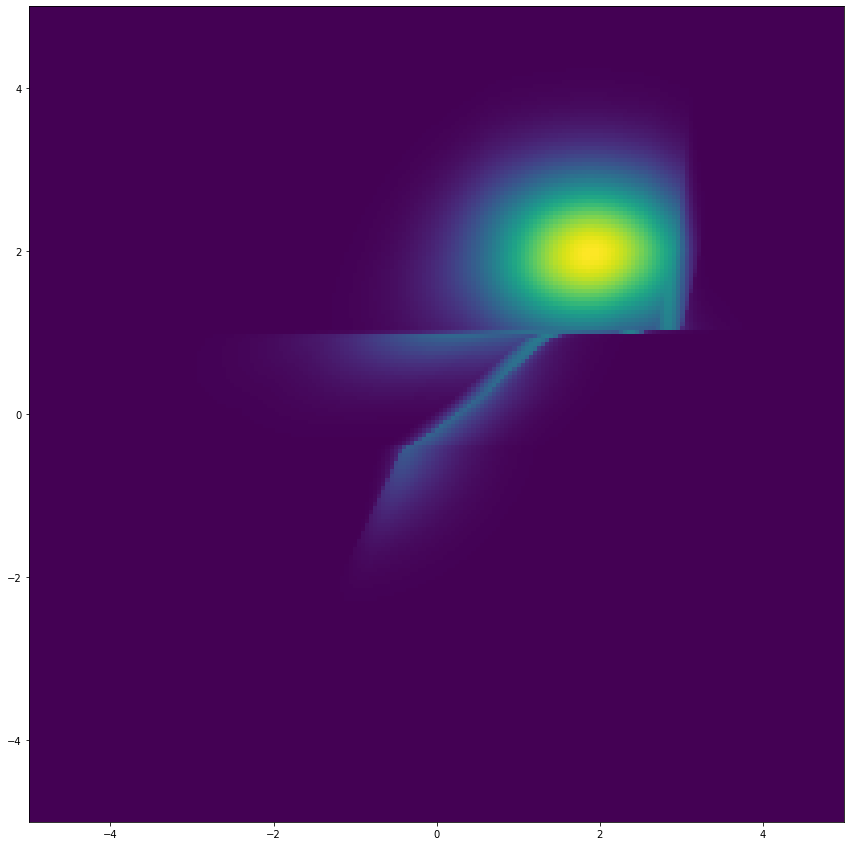

100%|█████████▉| 3999/4000 [15:46<00:00,  4.59it/s]

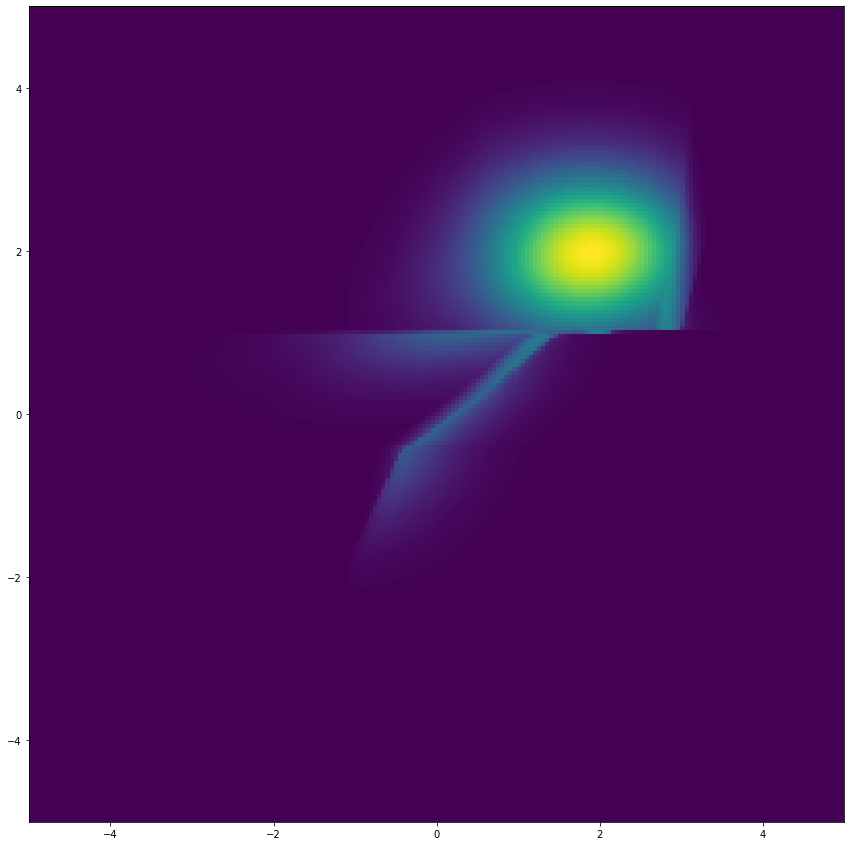

100%|██████████| 4000/4000 [15:46<00:00,  4.22it/s]


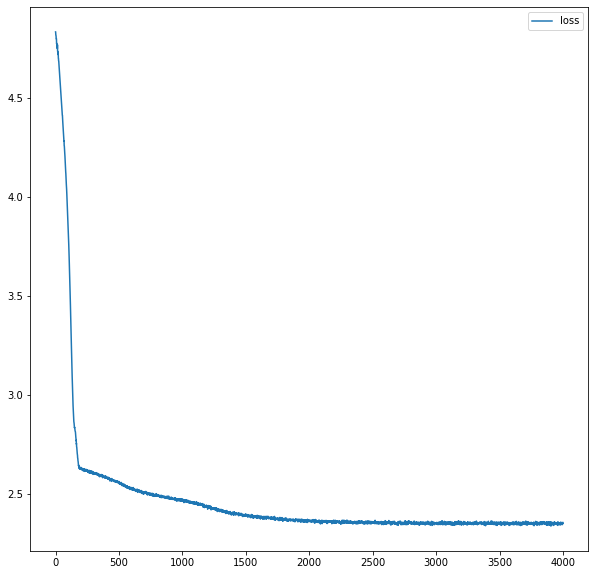

In [8]:
# Train model
max_iter = 4000
num_samples = 100000
show_iter = 500


loss_hist = np.array([])

optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-5)

for it in tqdm(range(max_iter)):
    optimizer.zero_grad()
    
    # Get training samples
    x_np = nu.forward(num_samples)[0].numpy()
    x = torch.tensor(x_np).float()
    
    # Compute loss
    loss = model.forward_kld(x)
    
    # Do backprop and optimizer step
    if ~(torch.isnan(loss) | torch.isinf(loss)):
        loss.backward()
        optimizer.step()
    
    # Log loss
    loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())

    writer.add_scalar('Loss', loss_hist[-1], it)

    
    # Plot learned posterior
    if (it + 1) % show_iter == 0:
        model.eval()
        log_prob = model.log_prob(zz)
        model.train()
        prob = torch.exp(log_prob.to('cpu').view(*xx.shape))
        prob[torch.isnan(prob)] = 0

        fig = plt.figure(figsize=(15, 15))
        plt.pcolormesh(xx, yy, prob.data.numpy())
        plt.gca().set_aspect('equal', 'box')
        plt.show()

        writer.add_figure('Distribution', fig, it)

# Plot loss
plt.figure(figsize=(10, 10))
plt.plot(loss_hist, label='loss')
plt.legend()
plt.show()

writer.add_hparams({"max_iter":max_iter, "num_samples":num_samples},
                    {"loss": loss_hist[-1]})

In [9]:
writer.close()